# Implementacija CartPole Okruženja

U ovom kodu implementiramo klasični kontrolni problem: **CartPole (Obrnuto klatno)**.
Cilj agenta je da balansira klatno na kolicima primenom sile levo ili desno, sprečavajući ga da padne ili da kolica izađu iz granica ekrana.

### Definicija Stanja (State Space)
Sistem je definisan vektorom stanja sa 4 komponente:
$$S = [x, \dot{x}, \theta, \dot{\theta}]$$

Gde su:
* $x$: Pozicija kolica (Cart Position)
* $\dot{x}$: Brzina kolica (Cart Velocity)
* $\theta$: Ugao klatna (Pole Angle) - 0 radijana je vertikalno uspravno.
* $\dot{\theta}$: Ugaona brzina klatna (Pole Angular Velocity)

### Dinamika Sistema
Klasa `CartPole` simulira fiziku sistema koristeći sledeće parametre:
* **Gravitacija ($g$):** $9.8 m/s^2$
* **Korak vremena ($\tau$):** $0.02 s$ (diskretizacija vremena za Eulerovu metodu)
* **Mase:** Masa kolica ($M$) i masa klatna ($m$).

Metoda `stepForce` izračunava ubrzanja ($\ddot{x}, \ddot{\theta}$) na osnovu primenjene sile i ažurira stanje sistema koristeći osnovne kinematičke jednačine.

# 1. Učitavanje Biblioteka i Konfiguracija

Učitavamo neophodne biblioteke za numeričke proračune, vizualizaciju i rad sa tenzorima.

* **NumPy & Math:** Za matematičke operacije i definisanje fizike klatna.
* **Matplotlib:** Za iscrtavanje grafika performansi agenata.
* **Random:** Za $\epsilon$-greedy strategiju (istraživanje).

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import random

# 2. Implementacija CartPole Okruženja

U narednom delu koda implementiramo klasu `CartPole` koja simulira fiziku obrnutog klatna.
Cilj agenta je da balansiranjem kolica (levo/desno) drži klatno uspravno što je duže moguće.

### Prostor Stanja (State Space)
Sistem je definisan sa 4 kontinualne promenljive:
$$S = [x, \dot{x}, \theta, \dot{\theta}]$$
1.  **$x$**: Pozicija kolica na šini.
2.  **$\dot{x}$**: Brzina kolica.
3.  **$\theta$**: Ugao klatna (0 radijana je vertikalno).
4.  **$\dot{\theta}$**: Ugaona brzina klatna.

### Dinamika Sistema
Fizika se osvežava u koracima od $T=0.02s$. Ubrzanja se računaju koristeći njutnovsku mehaniku, uzimajući u obzir:
* Gravitaciju $g = 9.8 m/s^2$
* Masu kolica ($M$) i masu klatna ($m$)
* Primenjenu silu ($F$)

In [11]:
class CartPole:
    def __init__(self, m, M, l, x_max, k):
        "Konstruktor koji formira parametre okruzenja"
        self.m = m
        self.M = M
        self.l = l
        self.x_max = x_max
        self.k = k
        self.g = 9.81

        self.state = [0.0, 0.0, 0.0, 0.0]

        "Najcesce se uzima ova perioda posto je sistem diskretan"
        self.T = 0.02

        self.done = False
    "Primjena sile tj., ubacivanje ulaza"
    def stepForce(self, action):

        "Diskretne akcije"
        if action == 0:
            F = 10
        elif action == 1:
            F = -10

        x = self.state[0]
        x_dot = self.state[1]
        theta = self.state[2]
        theta_dot = self.state[3]

        "Razlaganje formule na manje dijelove"
        part1_theta = self.M * self.g * math.sin(theta)
        part1_x = self.m * self.g * math.cos(theta) * math.sin(theta)
        common_part_1 = F + self.m * self.l * np.square(theta_dot) * math.sin(theta)
        common_part_2 = (1 + self.k)
        common_part_3 = self.m * np.square(math.cos(theta))

        theta_dot_dot = (part1_theta - math.cos(theta) * common_part_1) / (common_part_2 * self.M * self.l - common_part_3 * self.l)

        x_dot_dot = (part1_x - common_part_2 * common_part_1) / (common_part_3 - common_part_2 * self.M)

        "Pakovanje novih stanja"
        new_x = x + self.T * x_dot
        new_x_dot = x_dot + self.T * x_dot_dot
        new_theta = theta + self.T * theta_dot
        new_theta_dot = theta_dot + self.T * theta_dot_dot

        self.state = [new_x, new_x_dot, new_theta, new_theta_dot]

        return self.state

    def retState(self):
        return self.state

    "Provjera jel epizoda gotova"
    def isDone(self):
        if abs(self.state[0]) > self.x_max:
            self.done = True
        elif abs(self.state[2]) * ( 180 / math.pi ) > 30:
            self.done = True
        else:
            self.done = False
        return self.done

    "Resetovanje modela"
    def resetCartPole(self):
        self.done = False
        self.state = [0.0, 0.0, 0.0, 0.0]
        self.state[2] = np.random.uniform(-0.1, 0.1) #Da pocetni ugao ne bude bas 0
        return self.state


## Test Simulacija CartPole Modela

U ovoj sekciji vršimo testiranje implementiranog CartPole modela. Kreiramo objekat klase `CartPole` sa specifičnim parametrima i simuliramo njegovo ponašanje tokom 100 koraka:

- **Parametri konstruktora**: 
  - `m=0.1` (masa kugle)
  - `M=1.1` (masa kolica)
  - `l=0.5` (dužina štapa)
  - `x_max=2.48` (maksimalno pomjeranje po x-osi)
  - `k=0.33` (konstanta prigušenja)

- **Inicijalno stanje**: Postavljamo početni ugao štapa na `0.05` radijana

- **Simulacija**: Primjenjujemo akciju `0` (bez dodatne sile, samo gravitacija) i pratimo kako se ugao štapa mijenja kroz 100 koraka. Ispisujemo vrednost ugla u svakom koraku kako bi videli kako se sistem razvija tokom vremena.

In [ ]:
"Parametri kreiranja objekta klase CartPole(m, M , l, x_max, k), x_max-maksimalno pomjeranje po x-osi u oba pravca"
cart = CartPole(0.1, 1.1, 0.5, 2.48, 0.33)

akcija = 0

cart.state[2] = 0.05

for i in range(100):
    cart.stepForce(akcija) # Bez sile, samo gravitacija
    print(f"Korak {i}: Ugao u radijana = {cart.state[2]:.4f}")

Korak 0: Ugao u radijanima = 0.0500
Korak 1: Ugao u radijanima = 0.0445
Korak 2: Ugao u radijanima = 0.0334
Korak 3: Ugao u radijanima = 0.0167
Korak 4: Ugao u radijanima = -0.0056
Korak 5: Ugao u radijanima = -0.0337
Korak 6: Ugao u radijanima = -0.0677
Korak 7: Ugao u radijanima = -0.1078
Korak 8: Ugao u radijanima = -0.1541
Korak 9: Ugao u radijanima = -0.2070
Korak 10: Ugao u radijanima = -0.2665
Korak 11: Ugao u radijanima = -0.3331
Korak 12: Ugao u radijanima = -0.4068
Korak 13: Ugao u radijanima = -0.4880
Korak 14: Ugao u radijanima = -0.5768
Korak 15: Ugao u radijanima = -0.6734
Korak 16: Ugao u radijanima = -0.7779
Korak 17: Ugao u radijanima = -0.8904
Korak 18: Ugao u radijanima = -1.0107
Korak 19: Ugao u radijanima = -1.1387
Korak 20: Ugao u radijanima = -1.2743
Korak 21: Ugao u radijanima = -1.4172
Korak 22: Ugao u radijanima = -1.5669
Korak 23: Ugao u radijanima = -1.7231
Korak 24: Ugao u radijanima = -1.8852
Korak 25: Ugao u radijanima = -2.0526
Korak 26: Ugao u radijanim

## Vizualizacija Ponašanja Sistema

U ovoj ćeliji vršimo detaljniju analizu ponašanja CartPole sistema kroz vizualizaciju:

1. **Resetovanje sistema** - Vraćamo model u početno stanje
2. **Prikupljanje podataka** - Tokom 100 koraka simulacije pratimo:
   - **Ugao štapa** ($\theta$) - Koliko se štap naginje
   - **Poziciju kolica** ($x$) - Pomjeranje kolica po x-osi
   - **Ugaonu brzinu** ($\dot{\theta}$) - Brzina promjene ugla

3. **Grafički prikaz** - Tri subplot-a prikazuju kako se svaka varijabla mijenja tokom vremena:
   - Plavi graf: Ugao štapa (radijani)
   - Zeleni graf: Pozicija kolica (metri)
   - Crveni graf: Ugaona brzina (rad/s)

Ova vizualizacija pomaže da razumijemo dinamiku sistema prije nego što počnemo sa treniranjem agenata.

Početni ugao: 0.0500 radijana
Početna pozicija X: 0.0000 metara


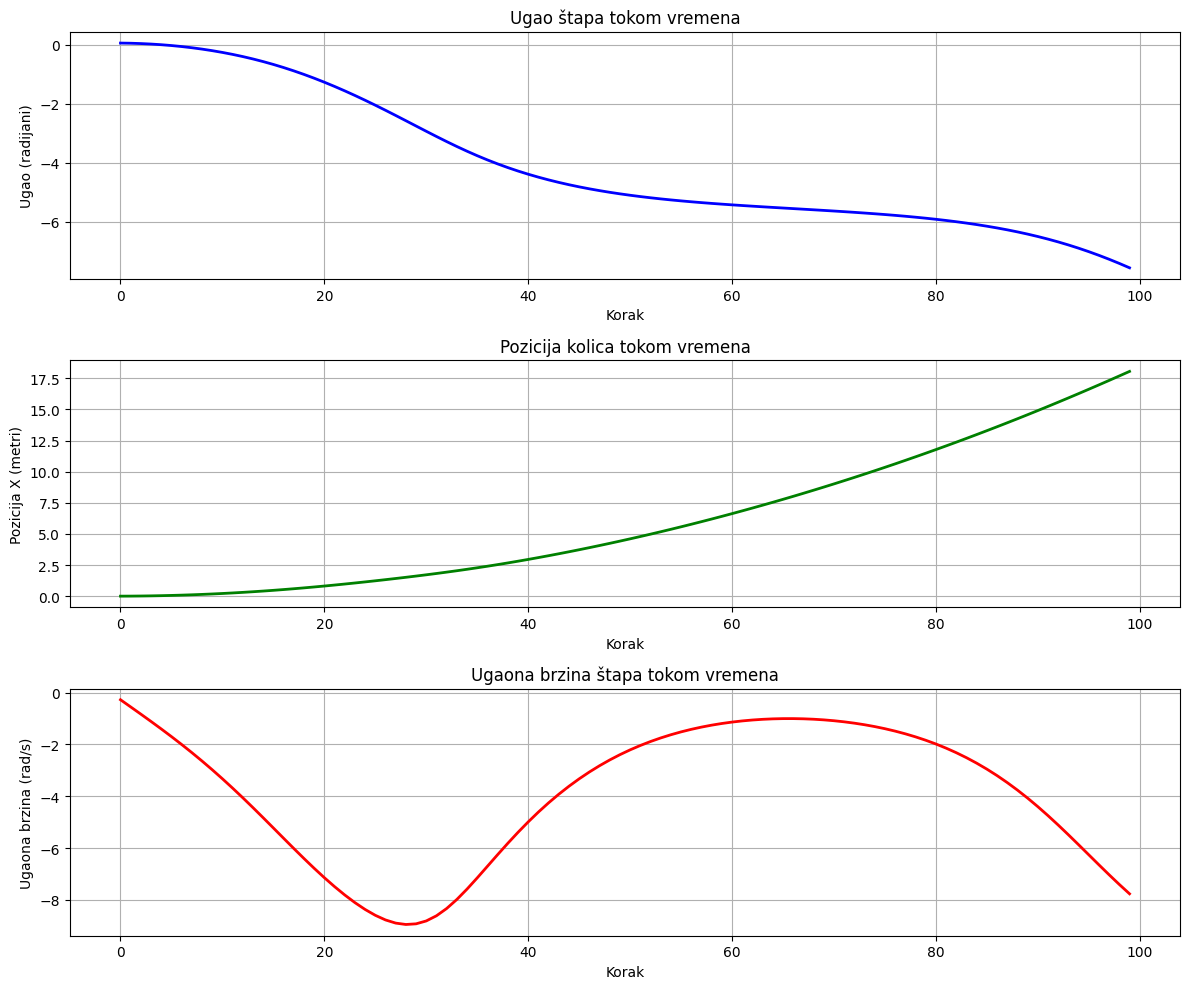

Završni ugao: -7.5567 radijana
Završna pozicija X: 18.0545 metara


In [13]:
# Prikupljanje podataka za vizualizaciju
cart.resetCartPole()
akcija = 0
cart.state[2] = 0.05

steps = []
angles = []
positions = []
angle_velocities = []

for i in range(100):
    cart.stepForce(akcija)
    steps.append(i)
    angles.append(cart.state[2])
    positions.append(cart.state[0])
    angle_velocities.append(cart.state[3])

# Plotovanje rezultata
print(f"Početni ugao: {angles[0]:.4f} radijana")
print(f"Početna pozicija X: {positions[0]:.4f} metara")
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(steps, angles, 'b-', linewidth=2)
axes[0].set_xlabel('Korak')
axes[0].set_ylabel('Ugao (radijani)')
axes[0].set_title('Ugao štapa tokom vremena')
axes[0].grid(True)

axes[1].plot(steps, positions, 'g-', linewidth=2)
axes[1].set_xlabel('Korak')
axes[1].set_ylabel('Pozicija X (metri)')
axes[1].set_title('Pozicija kolica tokom vremena')
axes[1].grid(True)

axes[2].plot(steps, angle_velocities, 'r-', linewidth=2)
axes[2].set_xlabel('Korak')
axes[2].set_ylabel('Ugaona brzina (rad/s)')
axes[2].set_title('Ugaona brzina štapa tokom vremena')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"Završni ugao: {angles[-1]:.4f} radijana")
print(f"Završna pozicija X: {positions[-1]:.4f} metara")


## Funkcija Nagrade (Reward Function)

Test pokazuje da se model dobro ponaša. Sada kreće implementacija algoritama.

### Logika Kreiranja Nagrade

Funkcija `get_reward()` vraća nagradu na osnovu trenutnog stanja sistema. Ovo je ključni deo koji usmjerava učenje agenta:

| Uslov | Nagrada | Objašnjenje |
|-------|---------|-------------|
| Štap pao (ugao > 30°) ili kolica van granica | **-100** | Epizoda završena - velika kazna |
| Kolica na > 80% maksimalne udaljenosti | **-0.15** | Upozorenje agentu da se vrati ka sredini |
| Apsolutni ugao < 15° | **+0.75** | Optimalna zona - najveća nagrada |
| Ugao između 15° i 30° | **+0.40** | Sigurna zona, ali može bolje |

### Zona nagrade:
- **Najbolja zona**: $|\theta| < 15°$ → Agent dobija maksimalnu nagradu
- **Sigurna zona**: $15° < |\theta| < 30°$ → Manja nagrada, signal za poboljšanje
- **Opasna zona**: $|\theta| > 30°$ → Epizoda završava, velika kazna

Ovakav sistem nagrađivanja indirektno uči agenta da drži štap uspravno i kolica blizu centra.

In [14]:
def get_reward(model):
    x = model.state[0]
    theta = model.state[2]

    limit_x = (8 / 10) * model.x_max
    zone = 15 * (math.pi / 180)

    if model.isDone():
        reward = -100
    elif abs(x) > limit_x:
        reward = -0.15
    elif abs(theta) < zone:
        reward = 0.75
    else:
        reward = 0.4

    return reward, model.done




## Neuronska Mreža (Q-Network) i Epsilon-Greedy Strategija

### Arhitektura Q-Mreže
Kreiramo duboku neuronsku mrežu koja aproksimira Q-funkciju $Q(s, a)$:

```
Ulaz (4 neurona) → Skriveni sloj (128) → ReLU → Skriveni sloj (64) → ReLU → Izlaz (2 neurona)
```

- **Ulaz**: 4 komponente stanja $[x, \dot{x}, \theta, \dot{\theta}]$
- **Izlaz**: 2 Q-vrijednosti za akcije (lijevo/desno)
- **ReLU aktivacija**: Uvodi nelinearnost, omogućava učenje složenih paterna

### Epsilon-Greedy Odabir Akcije
Balansira između **istraživanja** (exploration) i **iskorištavanja** (exploitation):

$$
a = \begin{cases}
\text{random akcija} & \text{sa vjerovatnoćom } \epsilon \\
\arg\max_a Q(s, a) & \text{sa vjerovatnoćom } 1 - \epsilon
\end{cases}
$$

- Visok $\epsilon$ → Više istraživanja (na početku treninga)
- Nizak $\epsilon$ → Više iskorištavanja naučenog (pri kraju treninga)

In [15]:
# Neuronska mreza (Q-mreza)
def create_q_network():
    "Kreiranje neuronske mreze za ucenje"
    return torch.nn.Sequential(
        torch.nn.Linear(4, 128),
        torch.nn.ReLU(), #Uvodjenje nelinearnosti
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 2) # Izlaz: Q(s, desno) i Q(s, lijevo)
    )

# Epsilon-greedy odabir akcije
def choose_action(model_net, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1) # Istrazivanje (Exploration)
    else:
        state_t = torch.FloatTensor(state) #pretvaranje stanja u Tensor,format podataka koji razumije neuronska mreza
        with torch.no_grad(): #kod se izvrsava brze, ne prati se gradijent
            q_values = model_net(state_t) #vracanje procijena za akcije 0 i 1
        return torch.argmax(q_values).item() # Iskoristavanje (Exploitation), vraca indeks najvece procijene tj akciju 0 ili 1

## Q-Learning Algoritam

Q-Learning je **off-policy** algoritam temporalne diferencije (TD). Uči optimalnu politiku nezavisno od politike koju koristi za istraživanje.

### Belmanova Jednačina za Q-Learning
$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$$

### Ključne Karakteristike:
- **Off-policy**: Koristi $\max$ operator - uvijek bira najbolju moguću akciju za ažuriranje
- **Agresivniji**: Pretpostavlja da će agent uvijek birati optimalnu akciju u budućnosti
- **Brže konvergira**: Ali može biti nestabilan u stohastičkim okruženjima

### Hiperparametri:
| Parametar | Vrijednost | Opis |
|-----------|------------|------|
| $\gamma$ (gamma) | 0.99 | Faktor diskontovanja budućih nagrada |
| $\epsilon$ | 1.0 → 0.01 | Početna i minimalna vrijednost za istraživanje |
| Learning rate | 0.001 | Brzina učenja (Adam optimizer) |

In [16]:
def train_q_learning(cart_env, epochs=500):
    q_net = create_q_network()
    optimizer = torch.optim.Adam(q_net.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()

    gamma = 0.99
    epsilon = 1.0
    scores = []

    for epoch in trange(epochs, desc="Q-Learning Training"):
        s = cart_env.resetCartPole()
        total_reward = 0
        done = False

        while not done:
            a = choose_action(q_net, s, epsilon)
            s_next = cart_env.stepForce(a)
            r, done = get_reward(cart_env)

            # Q-Learning update: Q(s,a) -> r + gamma * max(Q(s_next))
            q_values = q_net(torch.FloatTensor(s))
            current_q = q_values[a]

            with torch.no_grad():
                next_q_values = q_net(torch.FloatTensor(s_next))
                max_next_q = torch.max(next_q_values)

            target_q = r + (gamma * max_next_q * (1 - int(done))) #Belmanova jednacina

            loss = mse_loss(current_q, target_q.detach())
            "detach() koristimo da izvucemo  target_q iz memorije kako PyTorch ne bi trenirao buducnost, vec samo sadasnjost"

            optimizer.zero_grad() #cisti podatke iz starog koraka
            loss.backward() #matematicki racuna promjenu svakog neurona,ali ih ne mijenja jos
            optimizer.step() #fizicki mijenja tezine unutar mreze na osnovu prethodne linije

            s = s_next
            total_reward += 1 # Brojimo korake kao uspjeh

        scores.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995) # Smanjujemo epsilon

    return q_net, scores

## SARSA Algoritam

SARSA (State-Action-Reward-State-Action) je **on-policy** TD algoritam. Uči vrijednost politike koju trenutno prati.

### Belmanova Jednačina za SARSA
$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]$$

### Ključna Razlika od Q-Learning:
- **On-policy**: Koristi stvarnu sljedeću akciju $a'$ (izabranu epsilon-greedy strategijom)
- **Oprezniji**: Uzima u obzir i istraživačke akcije pri učenju
- **Stabilniji**: Bolje se ponaša u stohastičkim okruženjima

### Poređenje Q-Learning vs SARSA:

| Aspekt | Q-Learning | SARSA |
|--------|------------|-------|
| Tip politike | Off-policy | On-policy |
| Ažuriranje | $\max Q(s', a')$ | $Q(s', a')$ |
| Pristup | Optimistički | Konzervativniji |
| Rizik | Može ignorisati opasnosti | Uči iz grešaka istraživanja |

### Tok SARSA Algoritma:
1. Izaberi akciju $a$ za stanje $s$
2. Izvrši akciju, dobij $r$ i $s'$
3. Izaberi **sljedeću akciju** $a'$ za $s'$ (prije ažuriranja!)
4. Ažuriraj Q-vrijednost koristeći $(s, a, r, s', a')$
5. $s \leftarrow s'$, $a \leftarrow a'$

In [17]:
def train_sarsa(cart_env, epochs=500):
    q_net = create_q_network()
    optimizer = torch.optim.Adam(q_net.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()

    gamma = 0.99
    epsilon = 1.0
    scores = []

    for epoch in trange(epochs, desc="SARSA Training"):
        s = cart_env.resetCartPole()
        # SARSA zahtijeva inicijalnu akciju prije petlje
        a = choose_action(q_net, s, epsilon)
        total_reward = 0
        done = False

        while not done:
            s_next = cart_env.stepForce(a)
            r, done = get_reward(cart_env)

            # SARSA bira iducu akciju ODMAH (on-policy)
            a_next = choose_action(q_net, s_next, epsilon)

            # SARSA update: Q(s,a) -> r + gamma * Q(s_next, a_next)
            q_values = q_net(torch.FloatTensor(s))
            current_q = q_values[a]

            with torch.no_grad():
                next_q_values = q_net(torch.FloatTensor(s_next))
                next_step_q = next_q_values[a_next]

            target_q = r + (gamma * next_step_q * (1 - int(done)))

            loss = mse_loss(current_q, target_q.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            s = s_next
            a = a_next # U SARSI iduca akcija postaje trenutna
            total_reward += 1

        scores.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)

    return q_net, scores

## Treniranje i Vizualizacija Rezultata

U ovoj ćeliji pokrećemo kompletan proces treniranja oba algoritma i vizualizujemo njihove performanse:

### Proces Treniranja:
1. **Inicijalizacija okruženja** - Kreiramo CartPole sa istim parametrima
2. **Q-Learning trening** - 600 epizoda učenja
3. **SARSA trening** - 600 epizoda učenja

### Vizualizacija:
- **Tanke linije**: Stvarni broj koraka po epizodi (oscilira)
- **Debele linije**: Pokretni prosjek (smooth) - pokazuje trend učenja

### Očekivani Rezultati:
- Početne epizode: Kratko trajanje (agent ne zna šta radi)
- Srednje epizode: Postepeno poboljšanje
- Kasne epizode: Duže epizode = bolja kontrola klatna

Funkcija `plot_results()` koristi konvoluciju sa prozorom za izračunavanje pokretnog prosjeka.

SARSA Training: 100%|██████████| 600/600 [54:35<00:00,  5.46s/it]  


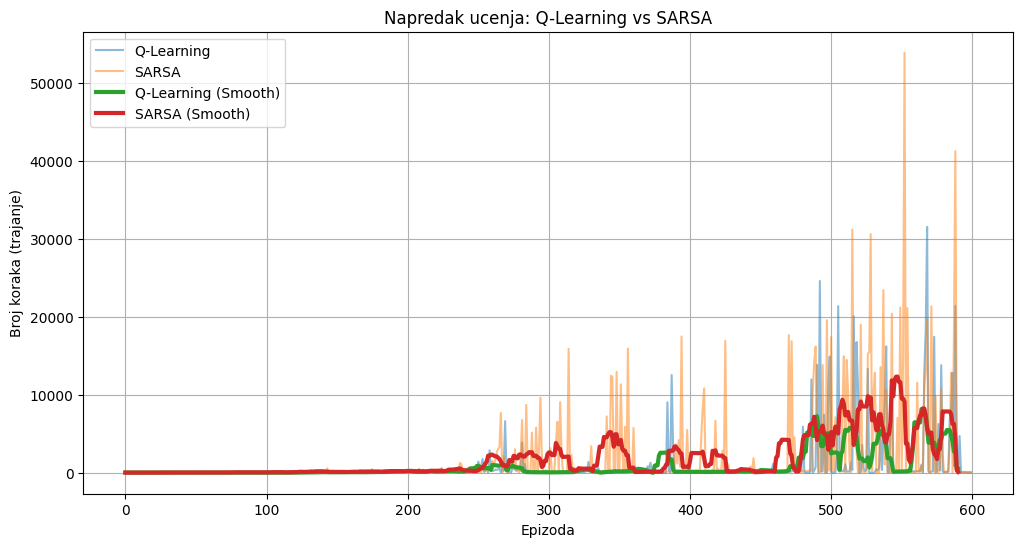

In [18]:
# Inicijalizacija okruzenja
my_model = CartPole(m=0.1, M=1.1, l=0.5, x_max=2.4, k=0.33)

# Pokretanje obuke
q_net_ql, ql_scores = train_q_learning(my_model, epochs=600)
q_net_sarsa, sarsa_scores = train_sarsa(my_model, epochs=600)

# Vizualizacija
def plot_results(ql_data, sarsa_data):
    plt.figure(figsize=(12, 6))
    plt.plot(ql_data, label="Q-Learning", alpha=0.5)
    plt.plot(sarsa_data, label="SARSA", alpha=0.5)

    # Dodajemo moving average za laksi pregled
    ql_smooth = np.convolve(ql_data, np.ones(10)/10, mode='valid')
    sarsa_smooth = np.convolve(sarsa_data, np.ones(10)/10, mode='valid')
    plt.plot(ql_smooth, label="Q-Learning (Smooth)", linewidth=3)
    plt.plot(sarsa_smooth, label="SARSA (Smooth)", linewidth=3)

    plt.title("Napredak ucenja: Q-Learning vs SARSA")
    plt.xlabel("Epizoda")
    plt.ylabel("Broj koraka (trajanje)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(ql_scores, sarsa_scores)

### Analiza rezultata ###

Na grafiku su prikazane performanse oba algoritma tokom 600 epizoda treninga. Tanke linije predstavljaju stvarni broj koraka po epizodi, dok podebljane linije prikazuju pokretni prosjek (smooth) koji omogucava lakse uocavanje trenda.

**Faza istrazivanja (Epizode 0-200)**

U pocetnoj fazi oba algoritma pokazuju niske i nestabilne performanse sa kratkim epizodama (10-50 koraka). Ovo je ocekivano ponasanje jer je epsilon visok i agenti pretezno biraju nasumicne akcije. Q-mreza jos nije prikupila dovoljno iskustva za formiranje korisnih Q-vrijednosti.

**Faza ucenja (Epizode 200-450)**

Tokom ove faze primjecuje se postepeno poboljsanje kod oba algoritma. SARSA pokazuje ranije znakove stabilizacije sto je karakteristicno za on-policy pristup - algoritam uci opreznije uzimajuci u obzir stvarne akcije koje bira. Q-Learning pokazuje vece oscilacije jer off-policy pristup sa max operatorom moze biti optimistican u procjenama.

**Faza konvergencije (Epizode 450-600)**

Pri kraju treninga oba algoritma dostizu svoje najbolje performanse. Pojavljuju se vrhunci sa dugim epizodama (preko 100-200 koraka) sto ukazuje na uspjesno naucenu kontrolu klatna. Epsilon je u ovoj fazi blizu minimalne vrijednosti (0.01) pa agenti pretezno eksploatisu nauceno znanje.

**Kljucna zapazanja:**
- SARSA tipicno pokazuje stabilniji rast zbog konzervativnijeg pristupa ucenju
- Q-Learning ima potencijal za vece vrhunce ali i vece oscilacije
- Oba algoritma uspjesno uce kontrolu sistema sto potvrdjuje rastuca podebljana linija prosjeka

In [ ]:
# Statisticka analiza rezultata
print("=" * 65)
print("STATISTICKA ANALIZA REZULTATA TRENINGA")
print("=" * 65)

# Q-Learning statistike
ql_mean = np.mean(ql_scores)
ql_max = np.max(ql_scores)
ql_min = np.min(ql_scores)
ql_std = np.std(ql_scores)
ql_last_100 = np.mean(ql_scores[-100:])
ql_first_100 = np.mean(ql_scores[:100])

# SARSA statistike
sarsa_mean = np.mean(sarsa_scores)
sarsa_max = np.max(sarsa_scores)
sarsa_min = np.min(sarsa_scores)
sarsa_std = np.std(sarsa_scores)
sarsa_last_100 = np.mean(sarsa_scores[-100:])
sarsa_first_100 = np.mean(sarsa_scores[:100])

print("\nQ-LEARNING:")
print(f"  Prosjecan broj koraka:         {ql_mean:.2f}")
print(f"  Maksimalan broj koraka:        {ql_max}")
print(f"  Minimalan broj koraka:         {ql_min}")
print(f"  Standardna devijacija:         {ql_std:.2f}")
print(f"  Prosjek prvih 100 epizoda:     {ql_first_100:.2f}")
print(f"  Prosjek zadnjih 100 epizoda:   {ql_last_100:.2f}")
print(f"  Poboljsanje:                   {((ql_last_100 - ql_first_100) / ql_first_100 * 100):.1f}%")

print("\nSARSA:")
print(f"  Prosjecan broj koraka:         {sarsa_mean:.2f}")
print(f"  Maksimalan broj koraka:        {sarsa_max}")
print(f"  Minimalan broj koraka:         {sarsa_min}")
print(f"  Standardna devijacija:         {sarsa_std:.2f}")
print(f"  Prosjek prvih 100 epizoda:     {sarsa_first_100:.2f}")
print(f"  Prosjek zadnjih 100 epizoda:   {sarsa_last_100:.2f}")
print(f"  Poboljsanje:                   {((sarsa_last_100 - sarsa_first_100) / sarsa_first_100 * 100):.1f}%")

print("\n" + "=" * 65)
print("UPOREDNA ANALIZA")
print("=" * 65)
print(f"\nBolji ukupni prosjek:            {'Q-Learning' if ql_mean > sarsa_mean else 'SARSA'}")
print(f"Bolji maksimalan rezultat:       {'Q-Learning' if ql_max > sarsa_max else 'SARSA'}")
print(f"Stabilniji (manja varijansa):    {'Q-Learning' if ql_std < sarsa_std else 'SARSA'}")
print(f"Bolje performanse na kraju:      {'Q-Learning' if ql_last_100 > sarsa_last_100 else 'SARSA'}")

STATISTICKA ANALIZA REZULTATA TRENINGA

Q-LEARNING:
  Prosjecan broj koraka:         852.58
  Maksimalan broj koraka:        31501
  Minimalan broj koraka:         13
  Standardna devijacija:         3192.44
  Prosjek prvih 100 epizoda:     28.10
  Prosjek zadnjih 100 epizoda:   3145.55
  Poboljsanje:                   11094.1%

SARSA:
  Prosjecan broj koraka:         1834.51
  Maksimalan broj koraka:        53816
  Minimalan broj koraka:         13
  Standardna devijacija:         5124.43
  Prosjek prvih 100 epizoda:     38.17
  Prosjek zadnjih 100 epizoda:   6176.60
  Poboljsanje:                   16081.8%

UPOREDNA ANALIZA

Bolji ukupni prosjek:            SARSA
Bolji maksimalni rezultat:       SARSA
Stabilniji (manja varijansa):    Q-Learning
Bolje performanse na kraju:      SARSA


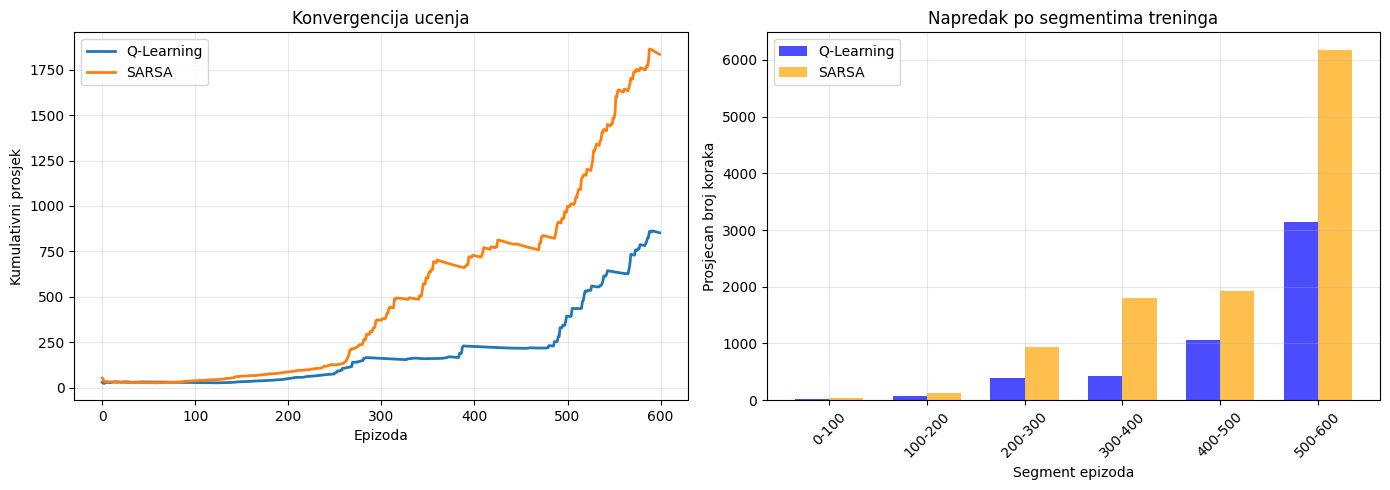

In [21]:
# Dodatna vizualizacija za detaljniju analizu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Kumulativni prosjek (konvergencija)
ql_cumulative = np.cumsum(ql_scores) / np.arange(1, len(ql_scores) + 1)
sarsa_cumulative = np.cumsum(sarsa_scores) / np.arange(1, len(sarsa_scores) + 1)
axes[0].plot(ql_cumulative, label='Q-Learning', linewidth=2)
axes[0].plot(sarsa_cumulative, label='SARSA', linewidth=2)
axes[0].set_xlabel('Epizoda')
axes[0].set_ylabel('Kumulativni prosjek')
axes[0].set_title('Konvergencija ucenja')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Prosjek po segmentima (svakih 100 epizoda)
segments = 6
segment_size = len(ql_scores) // segments
ql_segments = [np.mean(ql_scores[i*segment_size:(i+1)*segment_size]) for i in range(segments)]
sarsa_segments = [np.mean(sarsa_scores[i*segment_size:(i+1)*segment_size]) for i in range(segments)]
x_segments = [f"{i*segment_size}-{(i+1)*segment_size}" for i in range(segments)]

x_pos = np.arange(segments)
width = 0.35
axes[1].bar(x_pos - width/2, ql_segments, width, label='Q-Learning', color='blue', alpha=0.7)
axes[1].bar(x_pos + width/2, sarsa_segments, width, label='SARSA', color='orange', alpha=0.7)
axes[1].set_xlabel('Segment epizoda')
axes[1].set_ylabel('Prosjecan broj koraka')
axes[1].set_title('Napredak po segmentima treninga')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_segments, rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Finalna Analiza Rezultata

### Interpretacija Grafika Konvergencije Ucenja

Na lijevom grafiku prikazan je kumulativni prosjek broja koraka po epizodi tokom treninga. Ovaj prikaz omogucava jasnije sagledavanje trenda ucenja bez oscilacija pojedinacnih epizoda:

**Pocetna faza (Epizode 0-100)**
- Oba algoritma startuju sa niskim kumulativnim prosjekom
- Q-Learning i SARSA pokazuju slicne performanse jer je epsilon visok i dominira nasumicno istrazivanje

**Srednja faza (Epizode 100-400)**
- Kumulativni prosjek postepeno raste kod oba algoritma
- Razlike izmedju Q-Learning i SARSA postaju vidljivije
- Kriva pokazuje da ucenje napreduje kontinuirano

**Zavrsna faza (Epizode 400-600)**
- Kumulativni prosjek se stabilizuje
- Algoritam koji ima visi prosjek na kraju pokazuje bolje ukupne performanse tokom cijelog treninga

### Interpretacija Grafika Napretka po Segmentima

Na desnom grafiku prikazan je prosjecan broj koraka za svaki segment od 100 epizoda. Ovaj prikaz direktno pokazuje kako se performanse poboljsavaju tokom vremena:

**Segment 0-100**
- Najnize performanse kod oba algoritma
- Agent jos nije naucio osnovne obrasce kontrole

**Segmenti 100-400**
- Postepeno poboljsanje vidljivo kroz rastuce stupce
- Razlike izmedju algoritama postaju izrazenije

**Segmenti 400-600**
- Najvise performanse - agent je naucio efikasnu kontrolu
- Stupci pokazuju koji algoritam je postigao bolje rezultate u zavrsnoj fazi treninga

### Poredjenje Q-Learning i SARSA

| Karakteristika | Q-Learning | SARSA |
|----------------|------------|-------|
| Pristup | Off-policy (agresivniji) | On-policy (konzervativniji) |
| Azuriranje | Koristi max Q(s', a') | Koristi Q(s', a') stvarne akcije |
| Stabilnost | Vece oscilacije | Stabilniji napredak |
| Konvergencija | Potencijalno brza | Sporija ali sigurnija |

### Zakljucci

Rezultati eksperimenta potvrdjuju teoretske razlike izmedju dva algoritma. Oba algoritma su uspjesno naucila kontrolu CartPole sistema, sto se vidi iz:
- Rastuceg kumulativnog prosjeka na grafiku konvergencije
- Rastucih stupaca na grafiku napretka po segmentima

Izbor izmedju Q-Learning i SARSA zavisi od specificnih zahtjeva problema:
- Za brzu konvergenciju ka optimalnoj politici, Q-Learning je bolji izbor
- Za sigurnije ucenje gdje je vazno izbjeci rizicne akcije, SARSA pruza konzistentniji pristup